In [96]:
import pandas as pd
import numpy as np
import astropy.utils.data
from astropy.coordinates import SkyCoord,concatenate
import astropy.units as u
import datetime as _datetime
from astropy.io import fits as _fits
from astropy.coordinates import FK5,ICRS
from astropy.io import ascii
from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time

# Join sources from 200219 and 191213 together

## Load in sources for 200219 and 191213

In [97]:
df_200219=pd.read_csv('200219_results.csv')
df_191213=pd.read_csv('191213g_results.csv')
final_results=pd.concat([df_200219,df_191213], axis=0)
final_results=final_results.reset_index(drop=True)

print('Number of sources for S200219m : ', len(df_200219) )
print('Number of sources for S191213g : ', len(df_191213) )

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,3,4,5,6,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of sources for S200219m :  42075
Number of sources for S191213g :  2716


## Save PS1, GLADE and all sources to csvs for crossmatching

In [98]:
final_results_ps1=final_results[final_results['source']=='PS1']
final_results_glade=final_results[final_results['source']=='GLADE']

final_results_ps1[['our_id','RA','Dec']].to_csv('ps1_sources_for_gaia.csv')
final_results_glade[['our_id','RA','Dec']].to_csv('glade_sources_for_gaia.csv')
final_results[['our_id','source','RA','Dec']].to_csv('all_sources_for_gaia.csv')

## Rename columns to avoid multiple 'RA', 'Dec' columns

In [99]:

final_results['ra_glade']=final_results['RA'][final_results['source']=='GLADE']
final_results['dec_glade']=final_results['Dec'][final_results['source']=='GLADE']
#final_results.rename(columns={'RA':'ra_glade'}, inplace=True)
#final_results.rename(columns={'Dec':'dec_glade'}, inplace=True)

final_results = final_results.drop('RA', 1)
final_results = final_results.drop('Dec', 1)

## Add in the xmatch between GLADE and PS1

In [100]:
glade_ps1_crossmatch=pd.read_csv('gladecheck1arsecnew4_Lana_S.csv')

glade_ps1_crossmatch.rename(columns={'RA':'ra_glade'}, inplace=True)
glade_ps1_crossmatch.rename(columns={'DEC':'dec_glade'}, inplace=True)
glade_ps1_crossmatch.rename(columns={'ObjID':'objID'}, inplace=True)

### Only take closest crossmatched source

In [101]:
def sep(ra,dec,ra1,dec1):
    c1=SkyCoord(ra*u.deg, dec*u.deg)
    c2=SkyCoord(ra1*u.deg, dec1*u.deg)
    sep = c1.separation(c2)
    return sep.arcsecond

glade_ps1_crossmatch['separation']=np.abs(sep(glade_ps1_crossmatch['ra_glade'].values,glade_ps1_crossmatch['dec_glade'].values,glade_ps1_crossmatch['raMean'].values,glade_ps1_crossmatch['decMean'].values))
glade_ps1_crossmatch=glade_ps1_crossmatch.sort_values('separation').drop_duplicates(subset='our_id', keep='first')

### Combine with sources table to get PS columns for GLADE xmatched sources

In [102]:
# merge PS1 and glade crossmatch columns
#final_results = final_results.merge(glade_ps1_crossmatch, how = 'outer', on = ['our_id', 'our_id'])

df1 = final_results.set_index(["our_id"])
df2 = glade_ps1_crossmatch.set_index(["our_id"])

final_results = df1.combine_first(df2).reset_index()
#final_results=pd.concat([final_results,glade_ps1_crossmatch])
print(len(final_results))

44791


# Add Gaia DR3 xmatch

In [103]:
xmatch_ps1_only=pd.read_csv('gaia_ps1_xmatch_result.csv')
xmatch_all=pd.read_csv('all_xmatch_dr3_3.csv')

xmatch_all.rename(columns={'ra':'ra_xmatch'}, inplace=True)
xmatch_all.rename(columns={'dec':'dec_xmatch'}, inplace=True)

xmatch_all.rename(columns={'ra.1':'ra_gaia'}, inplace=True)
xmatch_all.rename(columns={'dec.1':'dec_gaia'}, inplace=True)


df1 = xmatch_all.set_index(["our_id"])
df2 = final_results.set_index(["our_id"])

xmatch_all = df1.combine_first(df2).reset_index()

In [104]:
print('Number of sources xmatched in Gaia :' , len(xmatch_all))

Number of sources xmatched in Gaia : 46532


# Make a cut on astrometric error and proper motion for PS1 sources only

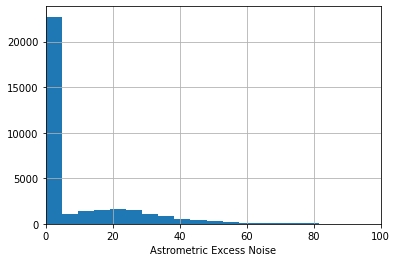

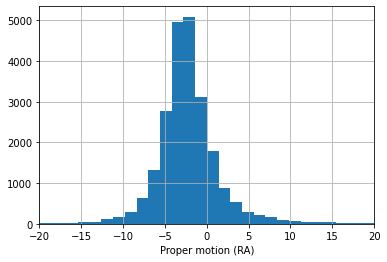

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline

sigs=xmatch_all['astrometric_excess_noise_sig'].values
xmatch_all['astrometric_excess_noise'].hist(bins=100)
plt.xlim(0,100)
plt.xlabel('Astrometric Excess Noise')
plt.show()

# xmatch_all['astrometric_excess_noise_sig'].hist(bins=10000)
# plt.xlim(0,100)
# plt.xlabel('Astrometric Excess Noise Sigma')
# plt.show()

xmatch_all['pmra'].hist(bins=100)
plt.xlabel('Proper motion (RA)')
plt.xlim(-20,20)
plt.show()



In [106]:
# UWE = https://www.cosmos.esa.int/documents/29201/1770596/Lindegren_GaiaDR2_Astrometry_extended.pdf
# xmatch_all['uwe']=np.sqrt(xmatch_all['astrometric_chi2_al']/(xmatch_all['astrometric_n_good_obs_al']-5))
# print('Min and Max astrometric error', np.nanmin(xmatch_all['uwe']), np.nanmax(xmatch_all['uwe']))
xmatch_all['pm_total']=np.sqrt(xmatch_all['pmra']**2+xmatch_all['pmdec']**2)
xmatch_all['pm_total_error']=np.sqrt(xmatch_all['pmra_error']**2+xmatch_all['pmdec_error']**2)

xmatch_all['pm_frac_error'] = xmatch_all['pm_total']/xmatch_all['pm_total_error']
print('Mean astrometric error and proper motion',np.mean(xmatch_all['astrometric_excess_noise']),np.mean(xmatch_all['pmra']))

Mean astrometric error and proper motion 9.195207842280562 -2.2048255533094654


In [107]:
print(list(xmatch_all.columns))

['our_id', '2MASS', 'AbsBMag', 'Bmag', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8', 'Column9', 'GWGC', 'Hmag', 'HyperLEDA', 'ID', 'Jmag', 'Kmag', 'PGC', 'SDSS', 'Unnamed: 0', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_gof_al', 'astrometric_matched_transits', 'astrometric_n_bad_obs_al', 'astrometric_n_good_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_obs_al', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_sigma5d_max', 'b', 'batchID', 'beta', 'bp_g', 'bp_rp', 'col1', 'cx', 'cy', 'cz', 'decMean', 'decMeanErr', 'decStack', 'decStackErr', 'dec_error', 'dec_gaia', 'dec_glade', 'dec_parallax_corr', 'dec_pmdec_corr', 'dec_pmra_corr', 'dec_pseudocolour_corr', 'dec_xmatch', 'designation', 'dist', 'dist_err', 'distance', 'dr2_radial_velocity', 'dr2_radial_velocity_error', 'dr2_rv_nb_transits', 'dr2_rv_template_fe_h', 'dr2_rv_template_logg', 'dr2_rv_template_teff', 'duplicated

In [112]:
xmatch_ps1_only=xmatch_all[xmatch_all['source']=='PS1']

xmatch_cut_1=xmatch_ps1_only[(xmatch_ps1_only['astrometric_excess_noise'].isna()) & (((xmatch_ps1_only['ra_gaia'])>315) | ((xmatch_ps1_only['ra_glade'])>315) |((xmatch_ps1_only['raMean'])>315) )  ]
xmatch_cut_2=xmatch_ps1_only[(xmatch_ps1_only['astrometric_excess_noise'].notna()) & (((xmatch_ps1_only['ra_gaia'])>315) | ((xmatch_ps1_only['ra_glade'])>315) |((xmatch_ps1_only['raMean'])>315) )  ]

print(len(xmatch_cut_1))
print(len(xmatch_cut_2))


xmatch_cut_1=xmatch_ps1_only[(xmatch_ps1_only['astrometric_excess_noise'].isna()) & ((((xmatch_ps1_only['ra_gaia'])<315) & ((xmatch_ps1_only['ra_gaia'])>306)) | (((xmatch_ps1_only['ra_glade'])<315) & ((xmatch_ps1_only['ra_glade'])>306)) |(((xmatch_ps1_only['raMean'])<315) & ((xmatch_ps1_only['raMean'])>306)) )  ]
xmatch_cut_2=xmatch_ps1_only[(xmatch_ps1_only['astrometric_excess_noise'].notna()) & ((((xmatch_ps1_only['ra_gaia'])<315) & ((xmatch_ps1_only['ra_gaia'])>306)) | (((xmatch_ps1_only['ra_glade'])<315) & ((xmatch_ps1_only['ra_glade'])>306)) |(((xmatch_ps1_only['raMean'])<315) & ((xmatch_ps1_only['raMean'])>306)) )  ]

print(len(xmatch_cut_1))
print(len(xmatch_cut_2))
#FITS_table_from_cat[(FITS_table_from_cat['GAIA_RA']>306) & (FITS_table_from_cat['GAIA_RA']<312)])

7990
9696
1402
20417


In [91]:
xmatch_ps1_only=xmatch_all[xmatch_all['source']=='PS1']
xmatch_GLADE_only=xmatch_all[xmatch_all['source']=='GLADE']

xmatch_cut_1=xmatch_ps1_only[((xmatch_ps1_only['astrometric_excess_noise_sig']>2) & (xmatch_ps1_only['astrometric_excess_noise']<20) | (xmatch_ps1_only['astrometric_excess_noise_sig']<=2)) | (xmatch_ps1_only['astrometric_excess_noise'].isna())]

xmatch_cut=xmatch_cut_1[(xmatch_cut_1['pm_total']<3*(xmatch_cut_1['pm_frac_error'])) | (xmatch_cut_1['pm_total'].isna())]

#xmatch_cut=xmatch_cut[(xmatch_cut['pmra']<(np.mean(xmatch_ps1_only['pmra'])+3*xmatch_ps1_only['pmra'].std())) & (xmatch_cut['pmra']>(np.mean(xmatch_ps1_only['pmra'])-3*xmatch_ps1_only['pmra'].std())) | (xmatch_cut['pmra']==np.nan) & (xmatch_cut['pmdec']<(np.mean(xmatch_ps1_only['pmdec'])+3*xmatch_ps1_only['pmdec'].std())) & (xmatch_cut['pmdec']>(np.mean(xmatch_ps1_only['pmdec'])-3*xmatch_ps1_only['pmdec'].std())) | (xmatch_cut['pmdec']==np.nan)]
print('Number of PS sources cut', len(xmatch_ps1_only)-len(xmatch_cut))
print('Number of PS sources not cut', len(xmatch_cut))

Number of PS sources cut 6087
Number of PS sources not cut 35948


# Recombine 'good' Gaia sources with GLADE sources

### i.e. keep GLADE sources no matter what the errors

In [92]:
xmatch_glade_ps1_cut=pd.concat([xmatch_cut,xmatch_GLADE_only], axis=0)
print('Number of PS sources not cut, plus all GLADE sources : ', len(xmatch_glade_ps1_cut))

Number of PS sources not cut, plus all GLADE sources :  40445


# If there are duplicate PS1 crossmatches, only take closest one

In [93]:
def sep(ra,dec,ra1,dec1):
    c1=SkyCoord(ra*u.deg, dec*u.deg)
    c2=SkyCoord(ra1*u.deg, dec1*u.deg)
    sep = c1.separation(c2)
    return sep.arcsecond

xmatch_glade_ps1_cut['separation']=np.abs(sep(xmatch_glade_ps1_cut['ra_gaia'].values,xmatch_glade_ps1_cut['dec_gaia'].values,xmatch_glade_ps1_cut['ra_xmatch'].values,xmatch_glade_ps1_cut['dec_xmatch'].values))
xmatch_glade_ps1_cut=xmatch_glade_ps1_cut.sort_values('separation').drop_duplicates(subset='our_id', keep='first')

In [94]:
total_cut_df = xmatch_glade_ps1_cut
print('Number of sources without duplicate xmatches', len(total_cut_df))

Number of sources without duplicate xmatches 38793


# Load the template FITS

In [95]:
template_hdulist = _fits.open('WS2021A1-003_CatalogueTemplate.fits')
template_primary_hdu = template_hdulist[0]
template_hdu = template_hdulist[1]
template_column_names = [col.name for col in template_hdu.columns]
print(template_column_names)


['CNAME', 'TARGSRVY', 'TARGPROG', 'TARGCAT', 'TARGID', 'TARGNAME', 'TARGPRIO', 'TARGUSE', 'TARGCLASS', 'PROGTEMP', 'OBSTEMP', 'GAIA_ID', 'GAIA_DR', 'GAIA_RA', 'GAIA_DEC', 'GAIA_EPOCH', 'GAIA_PMRA', 'GAIA_PMRA_ERR', 'GAIA_PMDEC', 'GAIA_PMDEC_ERR', 'GAIA_PARAL', 'GAIA_PARAL_ERR', 'HEALPIX', 'IFU_SPAXEL', 'IFU_PA', 'IFU_DITHER', 'MAG_G', 'MAG_G_ERR', 'MAG_R', 'MAG_R_ERR', 'MAG_I', 'MAG_I_ERR', 'GAIA_MAG_G', 'GAIA_MAG_G_ERR', 'GAIA_MAG_BP', 'GAIA_MAG_BP_ERR', 'GAIA_MAG_RP', 'GAIA_MAG_RP_ERR', 'APS_WL_MIN', 'APS_WL_MAX', 'APS_Z', 'APS_SIGMA', 'APS_TEMPL_LIB', 'APS_TEMPL_LIB_NORM', 'APS_PPXF_WL_MIN', 'APS_PPXF_WL_MAX', 'APS_PPXF_MOM', 'APS_PPXF_DEG_ADD', 'APS_PPXF_DEG_MULT', 'APS_PPXF_NUM_MC', 'APS_GAND_MODE', 'APS_GAND_ERR', 'APS_GAND_RED1', 'APS_GAND_RED2', 'APS_GAND_EBV', 'APS_LS_MODE', 'APS_LS_RES', 'APS_LS_NUM_MC', 'APS_SSP_NUM_WLKR', 'APS_SSP_NUM_CHAIN', 'APS_IFU_MASK', 'APS_IFU_TSSL_TYPE', 'APS_IFU_TSSL_TARG_SNR', 'APS_IFU_TSSL_MIN_SNR', 'APS_IFU_TSSL_COVAR', 'APS_IFU_SRC_ID', 'APS_IF

## Extension 0 Header

In [65]:
ext0_header=template_hdulist[0].header

#Set the catalogue submitter and CCs
ext0_header['CAT_NME1']='Lana'
ext0_header['CAT_NME2']='Salmon'
ext0_header['CAT_MAIL']='lana.salmon@ucdconnect.ie'
ext0_header['CAT_CC']='p.jonker@sron.nl,morgan.fraser@ucd.ie,lorraine.hanlon@ucd.ie,antonio.martin-carrillo@ucd.ie'
print(repr(ext0_header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT WS2021A1-003 Catalogue Template                                         
DATAMVER= '8.00    '           / WEAVE Data Model Version                       
TRIMESTE= '2021A1  '           / Observing Trimester                            
MAG_G_CM= '' / Survey specific mag column(s) used for MAG_G                     
MAG_R_CM= '' / Survey specific mag column(s) used for MAG_R                     
MAG_I_CM= '' / Survey specific mag column(s) used for MAG_I                     
STL_NME1= 'Peter   '                                                            
STL_NME2= 'Jonker  '                                                            
STL_MAIL= 'p.jonker@sron.nl'

## Extension 1 Header

In [66]:
ext1_header=template_hdulist[1].header
print(repr(ext1_header))

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1136 / length of dimension 1                          
NAXIS2  =                    0 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  113 / number of table fields                         
EXTNAME = 'WS2021A1-003 CATALOGUE' / extension name                             
TTYPE1  = 'CNAME   '           / WEAVE object name from coordinates             
TFORM1  = '20A     '           / data format of field: ASCII Character          
TDISP1  = 'A20     '           / Display format for column                      
TUCD1   = 'meta.id;meta.main

## Calculate Gaia mag errors

In [67]:
# according to dr2 https://www.cosmos.esa.int/documents/29201/1773953/Gaia+DR2+primer+version+1.3.pdf/a4459741-6732-7a98-1406-a1bea243df79?t=1581668739161
total_cut_df['phot_g_mean_mag_err']=1.086/total_cut_df['phot_g_mean_flux_over_error']
total_cut_df['phot_bp_mean_mag_err']=1.086/total_cut_df['phot_bp_mean_flux_over_error']
total_cut_df['phot_rp_mean_mag_err']=1.086/total_cut_df['phot_rp_mean_flux_over_error']

In [68]:
def GLADE_ID(df):
    df["GLADE_ID"] = df["HyperLEDA"].fillna(df["GWGC"])
    df["GLADE_ID"] = df["GLADE_ID"].fillna(df["PGC"])
    df["GLADE_ID"] = df["GLADE_ID"].fillna(df["SDSS"])
    df["GLADE_ID"] = df["GLADE_ID"].fillna(df["2MASS"])
    
GLADE_ID(total_cut_df)

## Take relevant columns from our catalogue

In [69]:
total_cut_df = total_cut_df.reset_index(drop=True)
FITS_table_from_cat=total_cut_df[['source','our_id','source_id','ra_gaia', 'dec_gaia', 'pmra', 'pmra_error',
                                  'pmdec', 'pmdec_error','parallax', 'parallax_error','phot_g_mean_mag',
                                  'phot_g_mean_mag_err','phot_bp_mean_mag','phot_bp_mean_mag_err',
                                  'phot_rp_mean_mag','phot_rp_mean_mag_err', 'gMeanKronMag', 'gMeanKronMagErr',
                                  'rMeanKronMag', 'rMeanKronMagErr','iMeanKronMag', 'iMeanKronMagErr',
                                  'objID', 'raMean', 'decMean',
                                  'gMeanKronMag', 'gMeanKronMagErr','iMeanKronMag', 'iMeanKronMagErr',
                                  'rMeanKronMag', 'rMeanKronMagErr','yMeanKronMag', 'yMeanKronMagErr','zMeanKronMag', 'zMeanKronMagErr',
                                  'ra_glade', 'dec_glade', 'GLADE_ID', 'Hmag', 'e_Hmag','Jmag', 'e_Jmag',  'Kmag', 'eKmag',
                                  'ra_glade', 'dec_glade', 'GLADE_ID','Bmag', 'e_Bmag'
                                ]]


FITS_table_from_cat.columns = ['COORDCAT','TARGID','GAIA_ID','GAIA_RA', 'GAIA_DEC', 'GAIA_PMRA', 'GAIA_PMRA_ERR', 
                               'GAIA_PMDEC', 'GAIA_PMDEC_ERR', 'GAIA_PARAL', 'GAIA_PARAL_ERR','GAIA_MAG_G', 
                               'GAIA_MAG_G_ERR', 'GAIA_MAG_BP', 'GAIA_MAG_BP_ERR', 
                               'GAIA_MAG_RP', 'GAIA_MAG_RP_ERR', 'MAG_G', 'MAG_G_ERR', 
                               'MAG_R', 'MAG_R_ERR', 'MAG_I', 'MAG_I_ERR',
                               'PS_ID', 'PS_RA', 'PS_DEC',
                               'PS_MAG_G', 'PS_MAG_G_ERR', 'PS_MAG_I', 'PS_MAG_I_ERR', 
                               'PS_MAG_R', 'PS_MAG_R_ERR', 'PS_MAG_Y', 'PS_MAG_Y_ERR', 'PS_MAG_Z', 'PS_MAG_Z_ERR',
                                'NIRCAT_RA',  'NIRCAT_DEC',  'NIRCAT_ID', 'NIRCAT_MAG_H', 'NIRCAT_MAG_H_ERR', 
                               'NIRCAT_MAG_J', 'NIRCAT_MAG_J_ERR', 'NIRCAT_MAG_K', 'NIRCAT_MAG_K_ERR',
                               'OPTCAT_RA', 'OPTCAT_DEC',   'OPTCAT_ID', 'OPTCAT_MAG_B', 'OPTCAT_MAG_B_ERR'
                              ]

FITS_table_from_cat.reset_index()
#survey identifier
FITS_table_from_cat['TARGSRVY']='WS2021A1-003'

#CNAME is set by WEAVE
FITS_table_from_cat['CNAME']=''

#optional personal name for programme/catalogue
FITS_table_from_cat['TARGPROG']='GW-galaxy'
FITS_table_from_cat['TARGCAT']='WS2021A1-003.fits'

#T for target, GALAXY
FITS_table_from_cat['TARGUSE']='T'
FITS_table_from_cat['TARGCLASS']='GALAXY'

# PROGTEMP for MOS LR 3x1020s 60min OB
FITS_table_from_cat['PROGTEMP']='11331'

#OBSTEMP for max airmass=1.8, moon dist=90 deg, 
#max sky brightness=20.5, max seeing = 1.3'', transparency=0.8
FITS_table_from_cat['OBSTEMP']='GAEAD'

#TARGNAME is the same as unique id
FITS_table_from_cat['TARGNAME']=FITS_table_from_cat['TARGID']

#TARGPRIO = 10.0 for GLADE galaxies
#For the rest, set according to 
FITS_table_from_cat['TARGPRIO']=float(10)

    
def DR (df):
    if df['source'] == 'GLADE' :
        return 'V2'
    else:
        return ''
def glade (df):
    if df['source'] == 'GLADE' :
        return 'GLADE'
    else:
        return ''
    
def gaia (df):
    if df['GAIA_ID']!='':
        return '3'
    else:
        return ''

def PS (df):
    if df['PS_ID']!='':
        return '2'
    else:
        return ''
    
# ID columns are strings
FITS_table_from_cat['GAIA_ID']=FITS_table_from_cat['GAIA_ID'].astype(str)
FITS_table_from_cat['PS_ID']=FITS_table_from_cat['PS_ID'].astype(str)
FITS_table_from_cat['OPTCAT_ID']=FITS_table_from_cat['OPTCAT_ID'].astype(str)
FITS_table_from_cat['NIRCAT_ID']=FITS_table_from_cat['NIRCAT_ID'].astype(str)

# Null values for ID columns should be empty strings
FITS_table_from_cat.loc[FITS_table_from_cat.GAIA_ID == 'nan', ['GAIA_ID']] = ''
FITS_table_from_cat.loc[FITS_table_from_cat.NIRCAT_ID == 'nan', ['NIRCAT_ID']] = ''
FITS_table_from_cat.loc[FITS_table_from_cat.OPTCAT_ID == 'nan', ['OPTCAT_ID']] = ''
FITS_table_from_cat.loc[FITS_table_from_cat.PS_ID == 'nan', ['PS_ID']] = ''

# only give NIRCAT/OPTCAT columns for GLADE galaxies.
FITS_table_from_cat['NIRCAT_DR']=total_cut_df.apply (lambda total_cut_df: DR(total_cut_df), axis=1)
FITS_table_from_cat['OPTCAT_DR']=total_cut_df.apply (lambda total_cut_df: DR(total_cut_df), axis=1)
FITS_table_from_cat['NIRCAT']=total_cut_df.apply (lambda total_cut_df: glade(total_cut_df), axis=1)
FITS_table_from_cat['OPTCAT']=total_cut_df.apply (lambda total_cut_df: glade(total_cut_df), axis=1)

#Only give Gaia/PS columns for sources crossmatched with either.
#FITS_table_from_cat['GAIA_DR']=FITS_table_from_cat.apply (lambda FITS_table_from_cat: gaia(FITS_table_from_cat), axis=1)
FITS_table_from_cat['PS_DR']=FITS_table_from_cat.apply (lambda FITS_table_from_cat: PS(FITS_table_from_cat), axis=1)
FITS_table_from_cat['GAIA_DR']='3'
FITS_table_from_cat['GAIA_EPOCH']=2016.0  
# PS nulls are -999 - set to nan
FITS_table_from_cat=FITS_table_from_cat.replace(-999.000000, np.nan)


# Set APS / IFU columns to the default by setting them to null

FITS_table_from_cat['APS_PPXF_MOM']=-1
FITS_table_from_cat['APS_FLAG'] =''
FITS_table_from_cat['IFU_SPAXEL']=''
FITS_table_from_cat['APS_Z']=np.nan
FITS_table_from_cat['APS_TEMPL_LIB']=''
FITS_table_from_cat['APS_GAND_EBV']=-1
FITS_table_from_cat['APS_GAND_ERR']=-1
FITS_table_from_cat['APS_TEMPL_LIB_NORM']=-1
FITS_table_from_cat['APS_IFU_TSSL_MIN_SNR'] =np.nan
FITS_table_from_cat['IFU_PA'] =np.nan
FITS_table_from_cat['IFU_DITHER'] =float(0)
FITS_table_from_cat['APS_WL_MIN'] =np.nan
FITS_table_from_cat['APS_IFU_TSSL_TYPE'] =''
FITS_table_from_cat['GENCAT_INFO'] =''
FITS_table_from_cat['APS_SSP_NUM_WLKR'] =-1
FITS_table_from_cat['APS_LS_NUM_MC'] =-1
FITS_table_from_cat['APS_PPXF_DEG_MULT'] =-1
FITS_table_from_cat['APS_GAND_MODE'] =-1
FITS_table_from_cat['APS_GAND_RED2'] =np.nan
FITS_table_from_cat['APS_PPXF_NUM_MC'] =-1
FITS_table_from_cat['APS_IFU_SRC_DEC']=np.nan
FITS_table_from_cat['APS_IFU_SRC_ID'] =''
FITS_table_from_cat['APS_LS_RES'] =np.nan
FITS_table_from_cat['APS_IFU_TSSL_COVAR'] =-1
FITS_table_from_cat['APS_SSP_NUM_CHAIN'] =-1
FITS_table_from_cat['HEALPIX'] =-1
FITS_table_from_cat['APS_LS_MODE'] =-1
FITS_table_from_cat['APS_WL_MAX'] =np.nan
FITS_table_from_cat['APS_IFU_MASK'] =-1
FITS_table_from_cat['APS_PPXF_DEG_ADD'] =-1
FITS_table_from_cat['APS_PPXF_WL_MAX'] =np.nan
FITS_table_from_cat['APS_IFU_TSSL_TARG_SNR'] =np.nan
FITS_table_from_cat['APS_GAND_RED1'] =np.nan
FITS_table_from_cat['APS_IFU_SRC_RA'] =np.nan
FITS_table_from_cat['APS_SIGMA'] =np.nan
FITS_table_from_cat['APS_PPXF_WL_MIN']=np.nan

# add spec or phot z from GLADE
def glade_spec_z (df):
    if df['flag2']==1:
        return df['z']
    else:
        return np.nan
    
def glade_phot_z (df):
    if df['flag2']==3:
        return df['z']
    else:
        return np.nan
    
FITS_table_from_cat['PHOTOZCAT_Z']=total_cut_df.apply (lambda total_cut_df: glade_phot_z(total_cut_df), axis=1)
FITS_table_from_cat['SPECZCAT_Z']=total_cut_df.apply (lambda total_cut_df: glade_spec_z(total_cut_df), axis=1)

FITS_table_from_cat['PHOTOZCAT_DR']= np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), 'V2','')
FITS_table_from_cat['SPECZCAT_DR']= np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), 'V2','')
FITS_table_from_cat['PHOTOZCAT']= np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), 'GLADE','')
FITS_table_from_cat['SPECZCAT']= np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), 'GLADE','')

FITS_table_from_cat['PHOTOZCAT_ID'] = np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_ID,'')
FITS_table_from_cat['SPECZCAT_ID'] = np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_ID,'')
FITS_table_from_cat['PHOTOZCAT_RA'] = np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_RA,np.nan)
FITS_table_from_cat['SPECZCAT_RA'] = np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_RA,np.nan)
FITS_table_from_cat['PHOTOZCAT_DEC'] = np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_DEC,np.nan)
FITS_table_from_cat['SPECZCAT_DEC'] = np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_DEC,np.nan)

FITS_table_from_cat['PHOTOZCAT_ID']=FITS_table_from_cat['PHOTOZCAT_ID'].astype(str)
FITS_table_from_cat['SPECZCAT_ID']=FITS_table_from_cat['SPECZCAT_ID'].astype(str)
FITS_table_from_cat.loc[FITS_table_from_cat.PHOTOZCAT_ID == 'nan', ['PHOTOZCAT_ID']] = ''
FITS_table_from_cat.loc[FITS_table_from_cat.SPECZCAT_ID == 'nan', ['SPECZCAT_ID']] = ''



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

# Set TARGPRIO based on magnitude and astrometric error

In [70]:
# check the magnitude of sources from PS1 and apply weights. If GLADE, set to 10.0.
# mags=FITS_table_from_cat['PS_MAG_R']
# minval= min(mags)
# maxval= max(mags)
# total_cut_df['normalized'] = (10-1)*(1.0-(mags-minval)/(maxval-minval))+1
# FITS_table_from_cat['TARGPRIO'] = np.where(FITS_table_from_cat.PS_ID!='', total_cut_df.normalized,float(10))
# FITS_table_from_cat.loc[FITS_table_from_cat.OPTCAT == 'GLADE', ['TARGPRIO']] = float(10)
FITS_table_from_cat['astrometric_excess_noise']=total_cut_df['astrometric_excess_noise']
FITS_table_from_cat['astrometric_excess_noise_sig']=total_cut_df['astrometric_excess_noise_sig']

mags=FITS_table_from_cat['PS_MAG_R']
minval= min(mags)
maxval= max(mags)

good_astro = FITS_table_from_cat[(FITS_table_from_cat['astrometric_excess_noise_sig']>2) & (FITS_table_from_cat['astrometric_excess_noise']<=10)]
mags=good_astro['PS_MAG_R']
minval= np.nanmin(mags)
maxval= np.nanmax(mags)

good_astro['normalized']=(10-6)*(1.0-(mags-minval)/(maxval-minval))+6

bad_astro = FITS_table_from_cat[(FITS_table_from_cat['astrometric_excess_noise_sig']>2) & (FITS_table_from_cat['astrometric_excess_noise']>10)]
mags=bad_astro['PS_MAG_R']
minval= np.nanmin(mags)
maxval= np.nanmax(mags)
bad_astro['normalized']=(6-1)*(1.0-(mags-minval)/(maxval-minval))+1

# no astro
no_astro = FITS_table_from_cat[(FITS_table_from_cat['astrometric_excess_noise_sig']<=2) | (FITS_table_from_cat['astrometric_excess_noise'].isna())]
mags=no_astro['PS_MAG_R']
minval= np.nanmin(mags)
maxval= np.nanmax(mags)
no_astro['normalized']=(10-1)*(1.0-(mags-minval)/(maxval-minval))+1

#print(len(good_astro),len(bad_astro))
overall_astro=pd.concat([good_astro,bad_astro], axis=0)
overall_astro=pd.concat([overall_astro,no_astro], axis=0)

#good astrometric error
#print(bad_astro[['uwe','normalized','rMeanKronMag','source']][good_astro['rMeanKronMag'].notna()])
FITS_table_from_cat['TARGPRIO'] = np.where(FITS_table_from_cat.PS_ID!='', overall_astro.normalized,float(10))
FITS_table_from_cat.loc[FITS_table_from_cat.OPTCAT == 'GLADE', ['TARGPRIO']] = float(10)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

## If we don't have Gaia RA/Dec, transform PS1/GLADE to J2016 and put this into Gaia_RA, Gaia_dec columns

In [ ]:
# Take PS or GLADE ra,dec,epoch
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5,ICRS
from astropy.io import ascii
# Read in decimal degree data, J2000 (FK5) coordinates
# ingest the coordinates
def precess(valra,valdec):
    c = SkyCoord(ra=valra, dec=valdec, unit='deg', frame='fk5')
    # print the coordinates
    # precess to J2015.5, i.e., Gaia reference system
    c_Gaia = c.transform_to(ICRS)
    # print the transformed coordinates
    ra=c_Gaia.ra.degree
    dec=c_Gaia.dec.degree
    return ra, dec


for t in range(0,len(FITS_table_from_cat)):
    if FITS_table_from_cat['GAIA_ID'][t]=='':
        if FITS_table_from_cat['PS_ID'][t]!='':
            #FITS_table_from_cat['GAIA_RA'][t]=FITS_table_from_cat['PS_RA'][t]
            #FITS_table_from_cat['GAIA_DEC'][t]=FITS_table_from_cat['PS_DEC'][t]
            FITS_table_from_cat['GAIA_RA'][t],  FITS_table_from_cat['GAIA_DEC'][t] = precess(FITS_table_from_cat['PS_RA'][t],FITS_table_from_cat['PS_DEC'][t])
            
            FITS_table_from_cat['GAIA_EPOCH'][t]=2016.0
        else:
            #FITS_table_from_cat['GAIA_RA'][t]=FITS_table_from_cat['OPTCAT_RA'][t]
            #FITS_table_from_cat['GAIA_DEC'][t]=FITS_table_from_cat['OPTCAT_DEC'][t]
            FITS_table_from_cat['GAIA_EPOCH'][t]=2016.0
            FITS_table_from_cat['GAIA_RA'][t],  FITS_table_from_cat['GAIA_DEC'][t] = precess(FITS_table_from_cat['OPTCAT_RA'][t],FITS_table_from_cat['OPTCAT_DEC'][t])

## Fill in source of Mag G, Mag R, Mag I columns

In [72]:
# give a list of the columns where the Mag_GRI column came from. 
mag_source_g=[]
mag_source_r=[]
mag_source_i=[]

for t in range(0,len(total_cut_df)):
    if total_cut_df['source'][t]=='GLADE':
        mag_source_g.append('PS_MAG_G')
        mag_source_r.append('PS_MAG_R')
        mag_source_i.append('PS_MAG_I')
    else:
        mag_source_g.append('PS_MAG_G')
        mag_source_r.append('PS_MAG_R')
        mag_source_i.append('PS_MAG_I')

ext0_header['MAG_G_CM']='|'.join(mag_source_g)
ext0_header['MAG_R_CM']='|'.join(mag_source_r)
ext0_header['MAG_I_CM']='|'.join(mag_source_i)

# Study new dataframe

In [73]:
pd.set_option('display.max_columns', None)
FITS_table_from_cat=FITS_table_from_cat[template_column_names]

# put a cut of 1.0 on gaia_mag_bp_err as it seems to go above 1?

FITS_table_from_cat['GAIA_MAG_BP_ERR'][FITS_table_from_cat['GAIA_MAG_BP_ERR']>1]=np.nan
display(FITS_table_from_cat)

,CNAME,TARGSRVY,TARGPROG,TARGCAT,TARGID,TARGNAME,TARGPRIO,TARGUSE,TARGCLASS,PROGTEMP,OBSTEMP,GAIA_ID,GAIA_DR,GAIA_RA,GAIA_DEC,GAIA_EPOCH,GAIA_PMRA,GAIA_PMRA_ERR,GAIA_PMDEC,GAIA_PMDEC_ERR,GAIA_PARAL,GAIA_PARAL_ERR,HEALPIX,IFU_SPAXEL,IFU_PA,IFU_DITHER,MAG_G,MAG_G_ERR,MAG_R,MAG_R_ERR,MAG_I,MAG_I_ERR,GAIA_MAG_G,GAIA_MAG_G_ERR,GAIA_MAG_BP,GAIA_MAG_BP_ERR,GAIA_MAG_RP,GAIA_MAG_RP_ERR,APS_WL_MIN,APS_WL_MAX,APS_Z,APS_SIGMA,APS_TEMPL_LIB,APS_TEMPL_LIB_NORM,APS_PPXF_WL_MIN,APS_PPXF_WL_MAX,APS_PPXF_MOM,APS_PPXF_DEG_ADD,APS_PPXF_DEG_MULT,APS_PPXF_NUM_MC,APS_GAND_MODE,APS_GAND_ERR,APS_GAND_RED1,APS_GAND_RED2,APS_GAND_EBV,APS_LS_MODE,APS_LS_RES,APS_LS_NUM_MC,APS_SSP_NUM_WLKR,APS_SSP_NUM_CHAIN,APS_IFU_MASK,APS_IFU_TSSL_TYPE,APS_IFU_TSSL_TARG_SNR,APS_IFU_TSSL_MIN_SNR,APS_IFU_TSSL_COVAR,APS_IFU_SRC_ID,APS_IFU_SRC_RA,APS_IFU_SRC_DEC,APS_FLAG,NIRCAT,NIRCAT_DEC,NIRCAT_DR,NIRCAT_ID,NIRCAT_MAG_H,NIRCAT_MAG_H_ERR,NIRCAT_MAG_J,NIRCAT_MAG_J_ERR,NIRCAT_MAG_K,NIRCAT_MAG_K_ERR,NIRCAT_RA,OPTCAT,OPTCAT_DEC,OPTCAT_DR,OPTCAT_ID,OPTCAT_MAG_B,OPTCAT_MAG_B_ERR,OPTCAT_RA,PHOTOZCAT,PHOTOZCAT_DEC,PHOTOZCAT_DR,PHOTOZCAT_ID,PHOTOZCAT_RA,PHOTOZCAT_Z,PS_DEC,PS_DR,PS_ID,PS_MAG_G,PS_MAG_G_ERR,PS_MAG_I,PS_MAG_I_ERR,PS_MAG_R,PS_MAG_R_ERR,PS_MAG_Y,PS_MAG_Y_ERR,PS_MAG_Z,PS_MAG_Z_ERR,PS_RA,SPECZCAT,SPECZCAT_DEC,SPECZCAT_DR,SPECZCAT_ID,SPECZCAT_RA,SPECZCAT_Z
0,,WS2021A1-003,GW-galaxy,WS2021A1-003.fits,200129_27430,200129_27430,7.486403,T,GALAXY,11331,GAEAD,1.84361e+18,3,310.299491,25.320607,2016.0,-0.807420,0.067101,-6.389853,0.072030,0.779974,0.078859,-1,,NaN,0.0,17.740900,0.098448,16.935499,0.035245,16.500999,0.032400,17.094930,0.000703,17.717443,0.019886,16.273594,0.006534,NaN,NaN,NaN,NaN,,-1,NaN,NaN,-1,-1,-1,-1,-1,-1,NaN,NaN,-1,-1,NaN,-1,-1,-1,-1,,NaN,NaN,-1,,NaN,NaN,,,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,,,NaN,NaN,NaN,,NaN,,,NaN,NaN,25.320607,2,1.38e+17,17.740900,0.098448,16.500999,0.032400,16.935499,0.035245,16.379900,0.032596,16.573299,0.026969,310.299491,,NaN,,,NaN,NaN
1,,WS2021A1-003,GW-galaxy,WS2021A1-003.fits,200129_18586,200129_18586,8.073930,T,GALAXY,11331,GAEAD,1.85627e+18,3,310.951228,27.135701,2016.0,3.233635,1.596984,-2.092881,1.630870,-2.894647,1.791958,-1,,NaN,0.0,19.905399,0.027082,18.744499,0.024533,18.143700,0.014096,20.580246,0.008635,19.738565,0.033888,17.907866,0.009629,NaN,NaN,NaN,NaN,,-1,NaN,NaN,-1,-1,-1,-1,-1,-1,NaN,NaN,-1,-1,NaN,-1,-1,-1,-1,,NaN,NaN,-1,,NaN,NaN,,,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,,,NaN,NaN,NaN,,NaN,,,NaN,NaN,27.135701,2,1.41e+17,19.905399,0.027082,18.143700,0.014096,18.744499,0.024533,17.600201,0.048265,17.865299,0.024296,310.951228,,NaN,,,NaN,NaN
2,,WS2021A1-003,GW-galaxy,WS2021A1-003.fits,200129_17133,200129_17133,8.820165,T,GALAXY,11331,GAEAD,1.84405e+18,3,311.091787,26.175161,2016.0,-1.936932,0.260681,-5.098620,0.295332,-0.207956,0.358154,-1,,NaN,0.0,18.805300,0.002357,17.736601,0.000002,17.891199,0.000003,19.369286,0.003073,19.747478,0.058073,18.757330,0.037825,NaN,NaN,NaN,NaN,,-1,NaN,NaN,-1,-1,-1,-1,-1,-1,NaN,NaN,-1,-1,NaN,-1,-1,-1,-1,,NaN,NaN,-1,,NaN,NaN,,,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,,,NaN,NaN,NaN,,NaN,,,NaN,NaN,26.175161,2,1.39e+17,18.805300,0.002357,17.891199,0.000003,17.736601,0.000002,18.145599,0.068485,NaN,NaN,311.091787,,NaN,,,NaN,NaN
3,,WS2021A1-003,GW-galaxy,WS2021A1-003.fits,200129_45561,200129_45561,8.471425,T,GALAXY,11331,GAEAD,1.8608e+18,3,308.769849,30.243858,2016.0,-4.444597,0.257493,-6.708178,0.296885,-0.046610,0.313279,-1,,NaN,0.0,19.413000,0.035653,18.541500,0.033897,18.961700,0.068380,19.512749,0.002691,20.214153,0.066113,18.680817,0.016412,NaN,NaN,NaN,NaN,,-1,NaN,NaN,-1,-1,-1,-1,-1,-1,NaN,NaN,-1,-1,NaN,-1,-1,-1,-1,,NaN,NaN,-1,,NaN,NaN,,,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,,,NaN,NaN,NaN,,NaN,,,NaN,NaN,30.243858,2,1.44293e+17,19.413000,0.035653,18.961700,0.068380,18.541500,0.033897,18.358601,0.066751,18.105200,0.038177,308.769849,,NaN,,,NaN,NaN
4,,WS2021A1-003,GW-galaxy,WS2021A1-003.fits,200129_26167,200129_26167,7.462334,T,GALAXY,11331,GAEAD,1.84349e+18,3,310.169663,24.843783,2016.0,-2.

## Final 191213g field

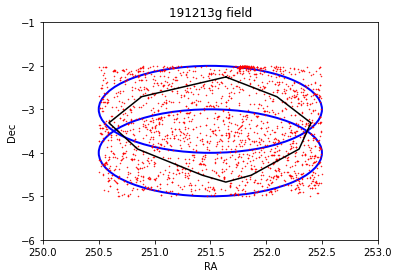

In [74]:
import lxml.etree
import healpy as hp
import astropy_healpix
import astropy.utils.data
from ligo.skymap.postprocess import crossmatch
from ligo.skymap.io import read_sky_map
import ligo.skymap.plot
from contours import contour_plots,join_0_360,split_contours,integrated_probability,hpix_contours
from skymapio import readskymap
from matplotlib.patches import Circle
payload = open('S191213g-4-Update.xml', 'rb').read()
root = lxml.etree.fromstring(payload)
params = {elem.attrib['name']:
              elem.attrib['value']
              for elem in root.iterfind('.//Param')}

graceid=params['GraceID']
prelim=params['AlertType']+params['Pkt_Ser_Num']

# Read the HEALPix sky map and the FITS header.
skymap, prob, distmu, distsigma, distnorm, npix, nside, distest, diststd = readskymap(params['skymap_fits'])

# Get the integrated probability map
csm=integrated_probability(prob)

# Identify the x% contours
contours=hpix_contours(csm,levels=[0.35],nest=False)
levels=[0.35]
levelsper=[35]

split_dec, split_ra = split_contours(contours, levels[0],0)
split_ra2, split_dec2=join_0_360(split_ra, split_dec)

plt.figure(1)
plt.plot(FITS_table_from_cat['GAIA_RA'], FITS_table_from_cat['GAIA_DEC'],'r.',markersize=1)
for r in range(0,len(split_ra2)):
    plt.plot(split_ra2[r],split_dec2[r],'k-')
    
circ_ra=[251.5,251.5]
circ_dec=[-3, -4]

for k in range(0,len(circ_ra)):
    plt.gca().add_patch(Circle((circ_ra[k],circ_dec[k]),radius=1,linewidth=2,edgecolor='b',facecolor='none'))

plt.xlim(250, 253)
plt.ylim(-6,-1)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('191213g field')
plt.savefig('191213_final.pdf')
plt.show()

In [75]:
print('Number of sources in field for S191213g : ', len(FITS_table_from_cat[(FITS_table_from_cat['GAIA_RA']>250) & (FITS_table_from_cat['GAIA_RA']<253) & (FITS_table_from_cat['GAIA_DEC']>-6) & (FITS_table_from_cat['GAIA_DEC']<-1)]))

Number of sources in field for S191213g :  2052


## Final S200129m field

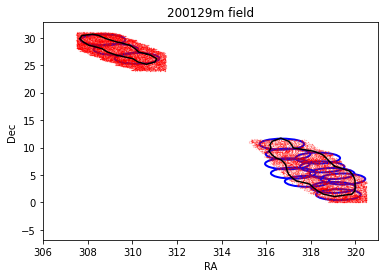

In [76]:
payload = open('S200129m-3-Initial.xml', 'rb').read()
root = lxml.etree.fromstring(payload)
params = {elem.attrib['name']:
              elem.attrib['value']
              for elem in root.iterfind('.//Param')}

graceid=params['GraceID']
prelim=params['AlertType']+params['Pkt_Ser_Num']

# Read the HEALPix sky map and the FITS header.
skymap, prob, distmu, distsigma, distnorm, npix, nside, distest, diststd = readskymap(params['skymap_fits'])

# Get the integrated probability map
csm=integrated_probability(prob)

# Identify the x% contours
contours=hpix_contours(csm,levels=[0.8],nest=False)
levels=[0.8]
levelsper=[80]

url='https://gracedb.ligo.org/api/superevents/'+graceid+'/files/LALInference.multiorder.fits'
skymap=read_sky_map(url, moc=True)

#separate masked array into separate contours
split_dec, split_ra = split_contours(contours, levels[0],0)
split_ra2, split_dec2=join_0_360(split_ra, split_dec)

plt.figure(1)
plt.plot(FITS_table_from_cat['GAIA_RA'], FITS_table_from_cat['GAIA_DEC'],'r.',markersize=0.1)

for r in range(0,len(split_ra2)):
    plt.plot(split_ra2[r],split_dec2[r],'k-')

circ_dec=[29.612335710496843, 27.85185949195497, 26.2477161548889,  10.620983658324782, 8.805241967316647, 8.07878740033157, 7.047288229257127, 5.341596273782272, 6.483618852135471, 3.852372305991949, 2.7427172969132414, 4.2772558616878555, 5.270703402542033, 1.4219625799321136]
circ_ra=[308.6869806094183,309.2686980609418,310.21606648199446,316.7045393542275,316.9835320123155,318.31237072708615,316.95208020841557,317.21364174626984,318.50477619010024,317.83689902897294,319.01122602036787,319.43961474698034,318.955143285703,319.2376411147075]

for k in range(0,len(circ_ra)):
    plt.gca().add_patch(Circle((circ_ra[k],circ_dec[k]),radius=1,linewidth=2,edgecolor='b',facecolor='none'))

plt.xlim(306, 321)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('200129m field')
plt.savefig('200129_final.pdf')
plt.show()

In [77]:
print('Number of sources in field for top contour S200129m : ', len(FITS_table_from_cat[(FITS_table_from_cat['GAIA_RA']>306) & (FITS_table_from_cat['GAIA_RA']<312)]))
print('Number of sources in field for bottom contour S200129m : ', len(FITS_table_from_cat[(FITS_table_from_cat['GAIA_RA']>315)]))

Number of sources in field for top contour S200129m :  19804
Number of sources in field for bottom contour S200129m :  16937


In [79]:
len(FITS_table_from_cat[(FITS_table_from_cat['GAIA_RA']<315) & (FITS_table_from_cat['GAIA_RA']>306) & (FITS_table_from_cat['OPTCAT']!='GLADE')])

19394

# Populate FITS file with this dict

In [32]:
import datetime as _datetime

from astropy.io import fits as _fits


def populate_fits_table_template(fits_template, data_dict, output_filename,
                                 header, update_datetime=True,
                                 checksum=True, overwrite=False):
    """
    Populate a FITS table template with the provided data.

    Parameters
    ----------
    fits_template : list of str
        A FITS template with a primary HDU and a first extension with a table.
    data_dict : dict
        A dictionary with the data. Its keys should contain the name of the
        columns of the table in the first extension of the FITS template. Its
        values should be array-like with the data to populate the table.
    output_filename : str
        The name of the output file which will be created.
    primary_kwds : dict, optional
        A dictionary with a list of keywords and their corresponding values
        which will be written a in the primary header (updated or added).
    update_datetime : bool, optional
        Update DATETIME keyword in the output file.
    checksum : bool, optional
        Add CHECKSUM and DATASUM keywords in the output file.
    overwrite : bool, optional
        Overwrite the output FITS file.
    """
    
    # Read the FITS template
    
    template_hdulist = _fits.open(fits_template)
    template_primary_hdu = template_hdulist[0]
    template_hdu = template_hdulist[1]
    
    # Check that all the columns are available in the dictionary with the data
    
    template_column_names = [col.name for col in template_hdu.columns]
    
    for col_name in template_column_names:
        assert col_name in data_dict.keys()
    
    # Create list of columns as described in the template populated with the
    # provided data
    
    column_list = []

    for col in template_hdu.columns:
        
        column = _fits.Column(name=col.name, format=col.format,
                             disp=col.disp, unit=col.unit, null=col.null,
                             array=list(data_dict[col.name].values()))
        
        column_list.append(column)
    
    
    # Create a HDU from the column list
    
    coldefs = _fits.ColDefs(column_list)

    hdu = _fits.BinTableHDU.from_columns(coldefs)
    
    # Copy the header from the template
    
    hdu.header = template_hdu.header
    
    # Create the primary extension and populate it with the provided information
    
    primary_hdu = template_primary_hdu
    
    #for kwd in primary_kwds.keys():
     #   primary_hdu.header[kwd] = primary_kwds[kwd]
    primary_hdu = header
    # Update the keyword DATETIME if requested (and it exists)
    
    if (update_datetime is True) and ('DATETIME' in primary_hdu.keys()):
        datetime_str = _datetime.datetime.utcnow().strftime(
                           '%Y-%m-%d %H:%M:%S.%f')
        primary_hdu['DATETIME'] = datetime_str
    primary_hdu=_fits.PrimaryHDU(header=primary_hdu)
    # Create a HDU list and save it to a file
    
    hdulist = _fits.HDUList([primary_hdu, hdu])
    hdulist.writeto(output_filename, checksum=checksum, overwrite=overwrite)
    

In [33]:
data_dicts=FITS_table_from_cat.to_dict()
ext0_header['CAT_NME1']='Lana'
ext0_header['CAT_NME2']='Salmon'
ext0_header['CAT_MAIL']='lana.salmon@ucdconnect.ie'
ext0_header['CAT_CC']='p.jonker@sron.nl,morgan.fraser@ucd.ie,lorraine.hanlon@ucd.ie,antonio.martin-carrillo@ucd.ie'

ext0_header['MAG_G_CM']='PS_MAG_G'
ext0_header['MAG_R_CM']='PS_MAG_R'
ext0_header['MAG_I_CM']='PS_MAG_I'

prim_header=ext0_header
# A dictionary of the catalogue
# A dictionary of the keywords for primary extension
populate_fits_table_template('WS2021A1-003_CatalogueTemplate.fits', data_dicts, 'WS2021A1-003.fits',
                                 prim_header, update_datetime=True,
                                 checksum=True, overwrite=True)